In [1]:
import cira

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [2]:
import pandas as pd 
import numpy as np
from typing import List, Dict

In [3]:
from datetime import datetime

IS_CACHED = True
SYMBOL = "TSLA"
SYM_HIST_FILE = f"./{SYMBOL}.csv"

stk = cira.Stock(SYMBOL)

if not IS_CACHED:
    start = datetime(2015, 7, 1)
    end = datetime(2023, 7, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()



,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,TSLA,230.72,231.38,219.00,223.41,6950990.0,69017.0,223.628998
2016-01-05 05:00:00+00:00,TSLA,226.36,226.89,220.00,223.43,3266892.0,31302.0,223.185093
2016-01-06 05:00:00+00:00,TSLA,220.00,220.05,215.98,219.04,3869402.0,33013.0,217.828005
2016-01-07 05:00:00+00:00,TSLA,214.19,218.44,213.67,215.65,3642624.0,33419.0,216.015211
2016-01-08 05:00:00+00:00,TSLA,217.86,220.44,210.77,211.00,3736631.0,32657.0,214.592999


<Axes: xlabel='timestamp'>

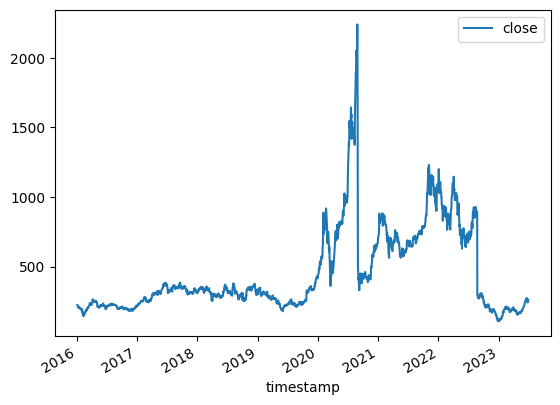

In [4]:
data.plot.line(y="close", use_index=True)

In [5]:
data = data.drop("symbol", axis=1)

In [6]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1886 1508 378


In [7]:

from numpy import ndarray
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from typing import List

from cira.strategy import Strategy
from cira.strategy.strategy import Randomness
from cira.strategy.backtest import back_test

class MyStrat(Strategy):
    def __init__(self, initial_capital=10_000, nr_random_walks=4, min_alocation=-10, max_alocation=10) -> None:
        super().__init__(name="MyStrat")
        self.model = RandomForestRegressor()
        self.nr_random_walks = nr_random_walks
        self.initial_capital = initial_capital
        self.min_alocation = min_alocation
        self.max_alocation = max_alocation


    def fit(self, train_data) -> None:
        price = pd.DataFrame()
        price["price"] = train_data["close"]

        # random walk  
        best_allocation = []
        best_result = 0
        for _ in range(self.nr_random_walks):
            r_model = Randomness(self.min_alocation, self.max_alocation)
            res = back_test(r_model, price, price , self.initial_capital, True)
            end_result = res.values[-1]
            if end_result - self.initial_capital > best_result:
               best_allocation = r_model.allocation
        
        assert best_allocation != [], "Warning walk did not yield positive return"
        #for i in range(len(best_allocation)):
        #    best_allocation[i] = best_allocation[i][0]
        
        # train model on best preforming random walk 
        y_train = np.array(best_allocation)
        self.model.fit(train_data, y_train)


    def predict(self, feature_data: DataFrame, prices: DataFrame, cash: float) -> ndarray:
        return np.array([int(self.model.predict(feature_data)[-1])])



/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/axel/Programs/repositories/cira/env/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarni

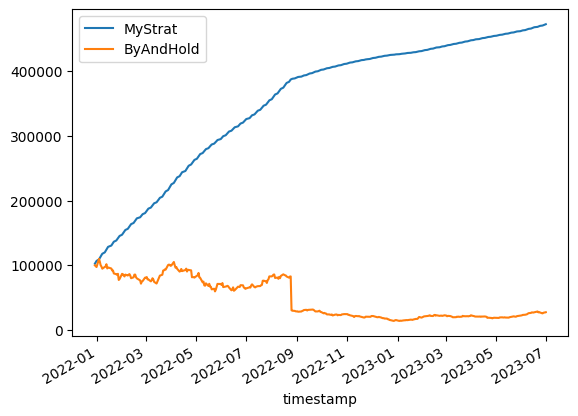

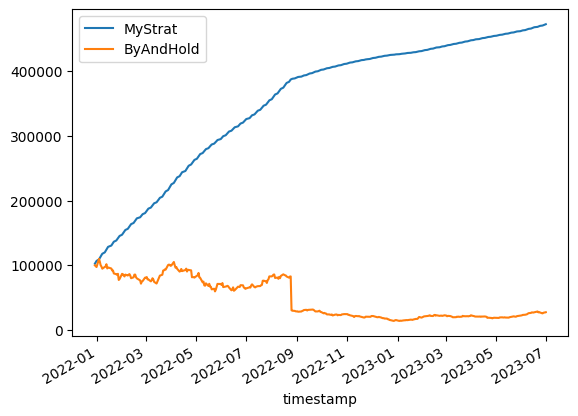

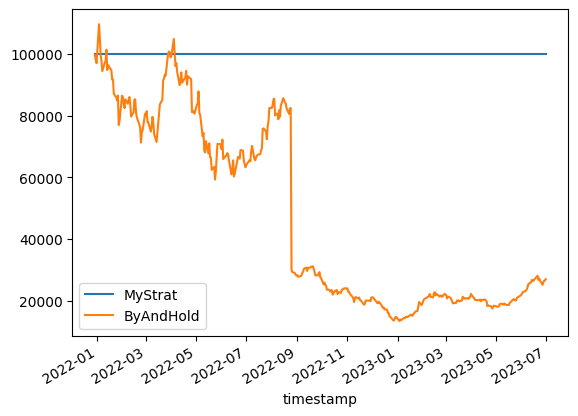

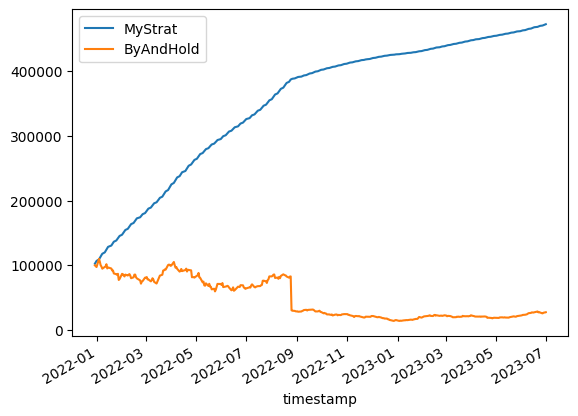

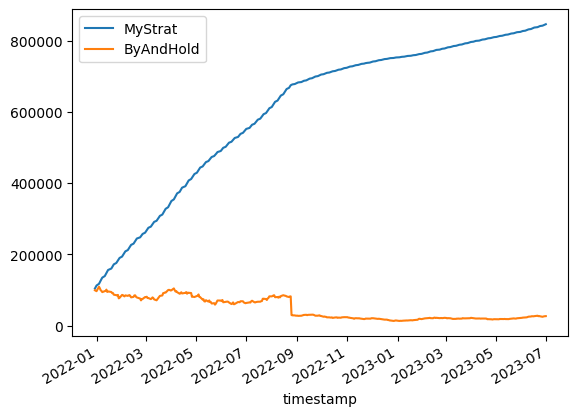

In [17]:
from cira.strategy.backtest import back_test_against_buy_and_hold

for _ in range(5):
    strat = MyStrat(nr_random_walks=10)
    strat.fit(train_data)

    price = pd.DataFrame()
    price["price"] = test_data["close"]
    back_test_against_buy_and_hold(strat, test_data, price, 100_000, True).plot()